<a href="https://colab.research.google.com/github/prithiba-A/Data-Science-Project-Series/blob/main/Nexus_Phase1_Project2_Breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Load the dataset
df = pd.read_csv('/content/breast-cancer-dataset.csv')
df

,S/N,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
0,1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
1,2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
2,3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
3,4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
4,5,2019,21,1,1,0,Right,0,Upper outer,1,Benign
...,...,...,...,...,...,...,...,...,...,...,...
208,209,2020,49,1,6,3,Right,1,Lower inner,1,Malignant
209,210,2020,28,1,3,0,Left,0,Upper inner,0,Benign
210,211,2020,22,1,1,0,Left,0,Upper outer,1,Benign
211,212,2020,19,1,1,0,Left,0,Lower inner,1,Benign


In [8]:
# Inspect the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   S/N               213 non-null    int64 
 1   Year              213 non-null    object
 2   Age               213 non-null    int64 
 3   Menopause         213 non-null    int64 
 4   Tumor Size (cm)   213 non-null    object
 5   Inv-Nodes         213 non-null    object
 6   Breast            213 non-null    object
 7   Metastasis        213 non-null    object
 8   Breast Quadrant   213 non-null    object
 9   History           213 non-null    object
 10  Diagnosis Result  213 non-null    object
dtypes: int64(3), object(8)
memory usage: 18.4+ KB
None


In [9]:
print(df.describe())

              S/N         Age   Menopause
count  213.000000  213.000000  213.000000
mean   107.000000   39.784038    0.666667
std     61.631972   14.096712    0.472515
min      1.000000   13.000000    0.000000
25%     54.000000   30.000000    0.000000
50%    107.000000   40.000000    1.000000
75%    160.000000   49.000000    1.000000
max    213.000000   77.000000    1.000000


In [10]:
print(df.isnull().sum())

S/N                 0
Year                0
Age                 0
Menopause           0
Tumor Size (cm)     0
Inv-Nodes           0
Breast              0
Metastasis          0
Breast Quadrant     0
History             0
Diagnosis Result    0
dtype: int64


In [11]:
# Step 1: Data Preprocessing

# Check if the 'id' column exists before dropping it
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
else:
    print("'id' column not found. Skipping drop.")

# Inspect the data
print("Columns in the dataset:", df.columns)
print(df.head())

# Map the target variable to binary values if needed
if 'diagnosis' in df.columns:
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
elif 'Diagnosis Result' in df.columns:
    df['Diagnosis Result'] = df['Diagnosis Result'].map({'Malignant': 1, 'Benign': 0})
else:
    print("Target variable not found. Please check the dataset.")

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Handle missing values for numeric columns using mean imputation
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Handle missing values for non-numeric columns using mode imputation
if len(non_numeric_cols) > 0:
    imputer_mode = SimpleImputer(strategy='most_frequent')
    df[non_numeric_cols] = imputer_mode.fit_transform(df[non_numeric_cols])

# Replace non-numeric entries like '#' with NaN
df.replace('#', np.nan, inplace=True)

# Drop any rows with NaN values in non-numeric columns
df.dropna(subset=non_numeric_cols, inplace=True)

# Ensure that only numeric columns are used for the next steps
df_numeric = df.select_dtypes(include=[np.number])

'id' column not found. Skipping drop.
Columns in the dataset: Index(['S/N', 'Year', 'Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes',
       'Breast', 'Metastasis', 'Breast Quadrant', 'History',
       'Diagnosis Result'],
      dtype='object')
   S/N  Year  Age  Menopause Tumor Size (cm) Inv-Nodes Breast Metastasis  \
0    1  2019   40          1               2         0  Right          0   
1    2  2019   39          1               2         0   Left          0   
2    3  2019   45          0               4         0   Left          0   
3    4  2019   26          1               3         0   Left          0   
4    5  2019   21          1               1         0  Right          0   

  Breast Quadrant History Diagnosis Result  
0     Upper inner       0           Benign  
1     Upper outer       0           Benign  
2     Lower outer       0           Benign  
3     Lower inner       1           Benign  
4     Upper outer       1           Benign  


In [12]:
# Step 2: Remove Outliers using Z-score

# Calculate Z-scores for the numeric columns
z_scores = np.abs(zscore(df_numeric))

# Filter out rows where the Z-score is greater than 3 for any numeric column
df_zscored = df_numeric[(z_scores < 3).all(axis=1)]

# Check the shape of the DataFrame to see how many rows were removed
print(f"Original data shape: {df.shape}")
print(f"Data shape after removing outliers: {df_zscored.shape}")

Original data shape: (205, 11)
Data shape after removing outliers: (205, 4)


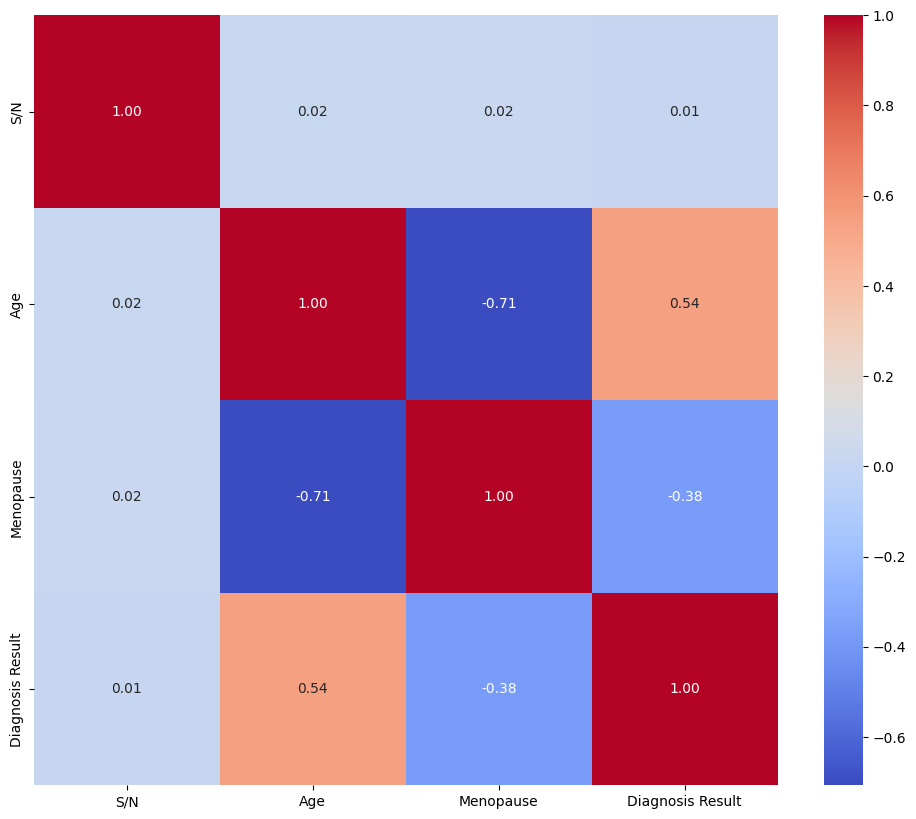

Highly correlated features: ['Age', 'Menopause', 'Diagnosis Result']


In [13]:
# Step 3: Feature Selection and Correlation Matrix

# Generate a correlation matrix using only numeric columns
corr_matrix = df_zscored.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Select highly correlated features with the target variable
threshold = 0.3
high_corr_features = corr_matrix.index[abs(corr_matrix['Diagnosis Result']) > threshold].tolist()
print(f"Highly correlated features: {high_corr_features}")

In [16]:
# Step 4: Model Training with SVM

# Update the feature set based on selected features
X = df_zscored[high_corr_features].drop(columns=['Diagnosis Result'])  # Ensure 'diagnosis' is the target variable
y = df_zscored['Diagnosis Result']

# Standardize the feature variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.6612903225806451
Confusion Matrix:
[[25  5]
 [16 16]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.83      0.70        30
         1.0       0.76      0.50      0.60        32

    accuracy                           0.66        62
   macro avg       0.69      0.67      0.65        62
weighted avg       0.69      0.66      0.65        62

